## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.



    Load your data into Tetrad, generating a Dataset object.
    Feed your data into a Search Algorithm.
    Choose search settings/assumptions that make sense, given how your data were collected.
    The output will be an equivalence class of graphs. Choose one plausible DAG from the output equivalence class.
    Choose a parametric model that makes sense for your data.
    Use your dataset to learn the parameters of the instantiated model.


# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 2000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
   
    return pd.DataFrame({'a' : a,'b' : b})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()






verbosity = 0

'''
models = [#[8,8,4],
          #[16,16,8],
          #LogisticRegression(), 
          #Perceptron(),  
          #DecisionTreeClassifier(),
          #LinearSVC(),
          #GaussianNB(),
          #[32,32,16],
          #[64,64,32],
          #[128, 128, 64],
          #[256, 256, 128],
          #[512, 512, 256],
          #[1024, 1024, 512],
          [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024], 
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
          #[2048, 2048, 1024],
         ]
model_names = ['n1', 
               'n2',
               'n3',
                'n4', 
               'n5',
               'n6',
                'n7', 
               'n8',
               'n9',

               #'m7', 
               #'m8',
               #'m9',
               #'m10', 
               #'m11a',
               #'m11b',
               #'m11c',
              ]
'''


models = []
model_names = []

num_models = 10
model_layers = [512, 256]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/b' + str(i))

print(models, model_names)


inputs = ['a',]
target = ['b']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values




/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256]] ['temp/b0', 'temp/b1', 'temp/b2', 'temp/b3', 'temp/b4', 'temp/b5', 'temp/b6', 'temp/b7', 'temp/b8', 'temp/b9']


In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/b0
temp/b1
temp/b2
temp/b3
temp/b4
temp/b5
temp/b6
temp/b7
temp/b8
temp/b9


In [4]:
## the size of the test set
nb_test = 2000


metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0,1,2]
variances = [1, 2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = inputs)
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = target)
            test_df2 = test_df2.join(test_targets2)




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


In [5]:
#the number of times to sample
times = 3
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a
full_conx = get_pairs(['a', 'b'])
forced_conx = set({('a','b')})
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)


Times =  0
['a --> b']
-4395.365242730462 -2820.4516476889175
['a --> b']
-4395.365242730462 -2722.0091345485653
['a --> b']
-4395.365242730462 -2779.544878637107
['a --> b']
-4395.365242730462 -2774.163943526243
['a --> b']
-4395.365242730462 -2876.144448422431
['a --> b']
-4395.365242730462 -2738.2052732715847
['a --> b']
-4395.365242730462 -2710.9713150854664
['a --> b']
-4395.365242730462 -2783.6373374627765
['a --> b']
-4395.365242730462 -2692.0430339280765
['a --> b']
-4395.365242730462 -2633.5847645221825
Times =  1
['a --> b']
-4336.892116460055 -2866.575288061039
['a --> b']
-4336.892116460055 -2815.3184198967356
['a --> b']
-4336.892116460055 -2837.742161526896
['a --> b']
-4336.892116460055 -2845.5522735064696
['a --> b']
-4336.892116460055 -2896.371121095405
['a --> b']
-4336.892116460055 -2806.8183949129293
['a --> b']
-4336.892116460055 -2788.5052795657493
['a --> b']
-4336.892116460055 -2883.554191949125
['a --> b']
-4336.892116460055 -2755.8844196491364
['a --> b']
-433

In [6]:
tetrad.scores

{'fisher-z': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@15623e74,
 'disc-mixed-bic': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@3e007a9c,
 'sem-bic-deterministic': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@2cecfc9a,
 'disc-bic': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@5d82fed4,
 'cond-gauss-bic': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@5917fa8e,
 'sem-bic': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@64febfaa,
 'mixed-var-polynominal-bic': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@2fbd9783,
 'conditional-gaussian-other-bic': Instance of edu.cmu.tetrad.annotation.AnnotatedClass: edu.cmu.tetrad.annotation.AnnotatedClass@658

Model_name =  temp/b0 Violations =  0.0
Average_violations =  -2877.195415831959 51.22023301277507
MSE =  1.029072849635826 0.03462368583328213
Model_name =  temp/b1 Violations =  0.0
Average_violations =  -2804.6614606624876 63.58278237673454
MSE =  1.0243812701730344 0.035464775591849365
Model_name =  temp/b2 Violations =  0.0
Average_violations =  -2847.4605978298787 59.81653900938927
MSE =  1.024969531119915 0.03345038142131783
Model_name =  temp/b3 Violations =  0.0
Average_violations =  -2852.8218608522507 67.38805759025635
MSE =  1.0291575596246525 0.034763774430768044
Model_name =  temp/b4 Violations =  0.0
Average_violations =  -2911.00476967 35.95848864475767
MSE =  1.0422234414258604 0.033088340215768605
Model_name =  temp/b5 Violations =  0.0
Average_violations =  -2812.4846355859804 63.08943225354658
MSE =  1.028046900960802 0.03094149299428447
Model_name =  temp/b6 Violations =  0.0
Average_violations =  -2778.777544601311 51.85050664507023
MSE =  1.0277650327408834 0.033

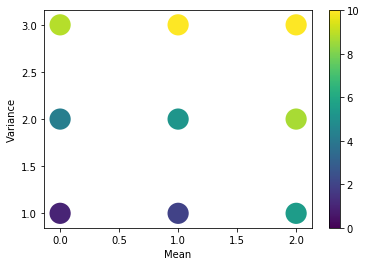

temp/b1
Area under surface (rectangular approx) =  60.45027212654249
Violations =  0.0
Average_violations =  -2804.6614606624876
MSE =  1.0243812701730344


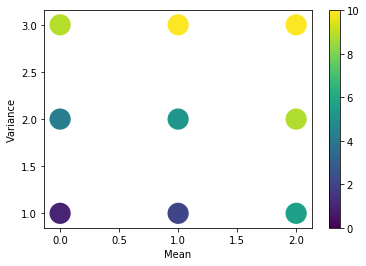

temp/b2
Area under surface (rectangular approx) =  61.80605240538259
Violations =  0.0
Average_violations =  -2847.4605978298787
MSE =  1.024969531119915


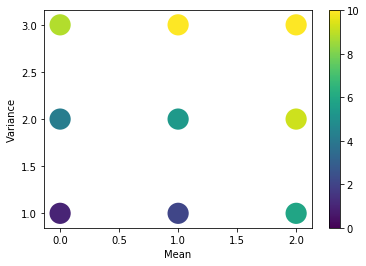

temp/b3
Area under surface (rectangular approx) =  63.73610901629411
Violations =  0.0
Average_violations =  -2852.8218608522507
MSE =  1.0291575596246525


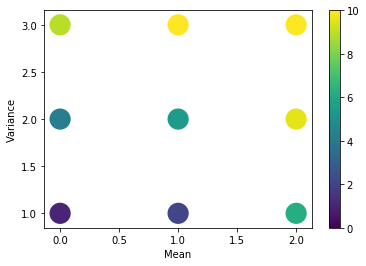

temp/b4
Area under surface (rectangular approx) =  60.647381156514
Violations =  0.0
Average_violations =  -2911.00476967
MSE =  1.0422234414258604


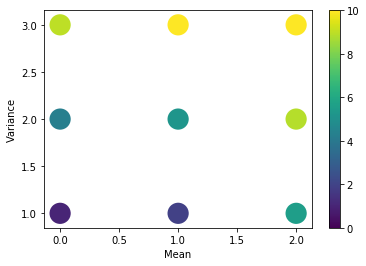

temp/b5
Area under surface (rectangular approx) =  59.4563385527518
Violations =  0.0
Average_violations =  -2812.4846355859804
MSE =  1.028046900960802


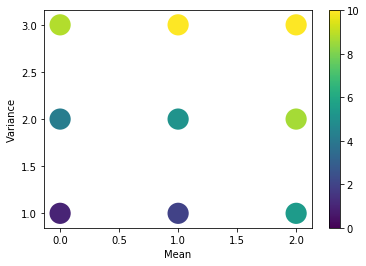

temp/b6
Area under surface (rectangular approx) =  60.01021290593701
Violations =  0.0
Average_violations =  -2778.777544601311
MSE =  1.0277650327408834


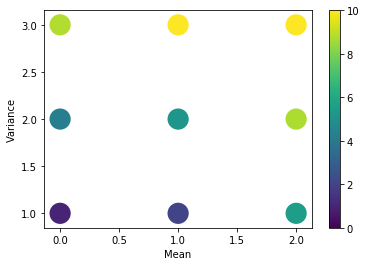

temp/b7
Area under surface (rectangular approx) =  61.873000056302764
Violations =  0.0
Average_violations =  -2861.6312748025325
MSE =  1.027081489213386


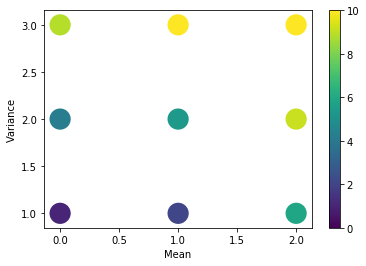

temp/b8
Area under surface (rectangular approx) =  63.38661050613456
Violations =  0.0
Average_violations =  -2761.1722982792453
MSE =  1.0355303243145284


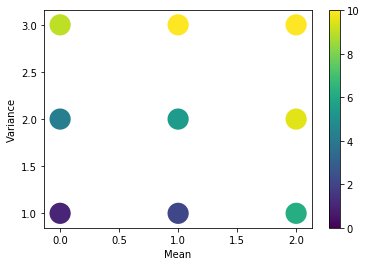

temp/b9
Area under surface (rectangular approx) =  62.3422373681689
Violations =  0.0
Average_violations =  -2726.2695202284135
MSE =  1.030589117488786


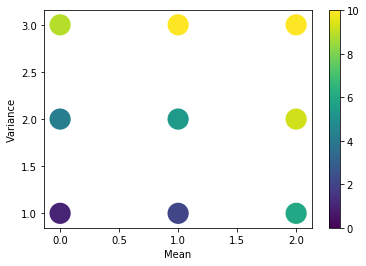

In [7]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

#bar_plot(model_names, 
#         np.array(metric), 
#         np.array(metric_err), 
#         np.array(viol), 
#         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    



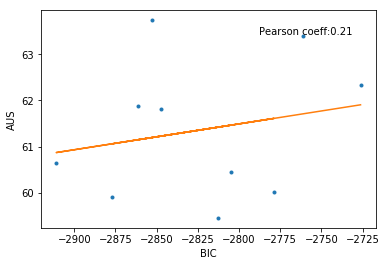

0.25699788713028876


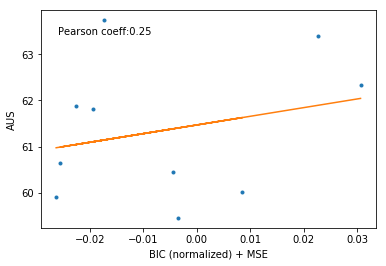

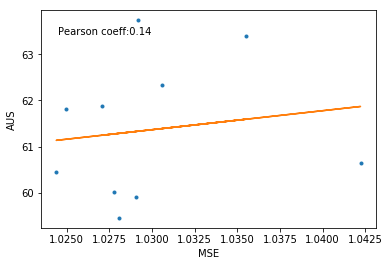

0.9730660065259478 -2.0123536452046058e-05


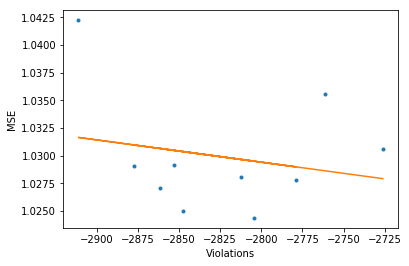

74.96221072205965 -6.487921215746216


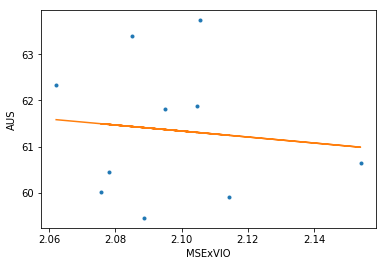

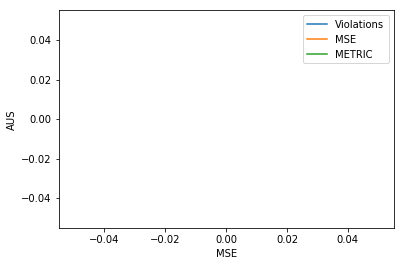

In [8]:
#VIO = 1/np.abs(VIO)
#VIO2 = np.abs(VIO2)
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.65, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex3ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC (normalized) + MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex3ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex3MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO,MSE, 1)
print(b,m)
ax.plot(VIO,MSE, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("MSE")
plt.show()





METRIC = (VIO/np.max(VIO)) + np.array(MSE)*np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
print(b,m)
ax.plot(METRIC,AUS, '.')
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSExVIO")
ax.set_ylabel("AUS")
plt.show()

MSE = np.array(MSE)
METRIC = VIO/np.max(VIO)+ MSE
x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'Violations')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
